# 0. Setup

In [1]:
!pip install matplotlib
import matplotlib.pyplot as plt
import keras.optimizers as optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras import models
from keras import regularizers
import math
import os
import pandas as pd

2022-12-29 09:23:35.327122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Hyperparameters

In [6]:
input_height = 69
input_width = 69
batch_size = 64

# TODO: find best parameters using the display_data_augmentation_sample jupyter notebook
rescale = True
if rescale:
    rescale_size=1./255
else:
    rescale_size=1
augmentation=True

rotation_range=40
width_shift_range=0.2
height_shift_range=0.2
shear_range=0.2
zoom_range=0.2
horizontal_flip=True
fill_mode='nearest'
# consider also stride (>1), type of pooling (Max, Avg), padding (same, valid)

In [7]:
# best loss function for multi-class classification, measures the distance between two probability distributions
# the probability distribution of the output of the network and the true distribution of the labels
loss_function='categorical_crossentropy'

metrics=['accuracy']
optimizer='rmsprop'
optimizer_learning_rate=1e-4
epochs=100
batch_size=32
#regularizer=regularizers.l1_l2(l1=0.001, l2=0.001) # simultaneous l1 and l2, add 0.001*weight_coefficient_value + 0.001 * 1/2*weight^2

if optimizer == 'rmsprop':
    optimizer=optimizers.RMSprop(learning_rate=optimizer_learning_rate)

In [13]:
paths = {
    'TRAIN_PATH' : os.path.join('workspace', 'images', 'train'),
    'TEST_PATH' : os.path.join('workspace', 'images','test'),
    'EVAL_PATH' : os.path.join('workspace', 'images','eval'),
    'IMAGES_PATH': os.path.join('workspace','images','all'),
    'ANNOTATION_PATH': os.path.join('workspace','annotations'),
    'ANNOTATION_FILE_PATH': os.path.join('workspace','annotations','annotations.csv'),
    'LOG_DIR' : os.path.join('model', 'log_dir')
 }

In [9]:
# create paths
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 2. Rebalance dataset

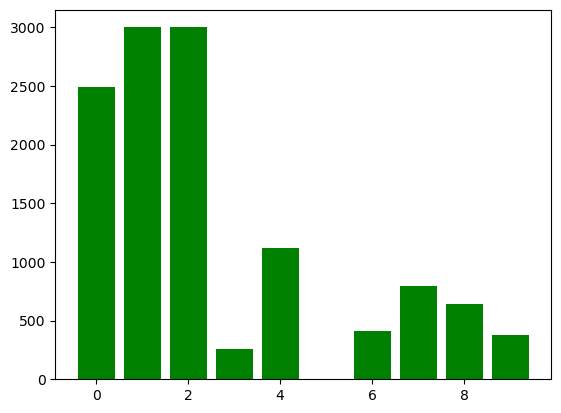

{0: 2488, 1: 3000, 2: 3000, 3: 257, 4: 1122, 6: 415, 7: 797, 8: 645, 9: 380}


In [19]:
def plotTrainingDistribution():
    files_per_label = dict()
    for i in range(10):
      if i == 5:
        continue
      path = os.path.join(paths['TRAIN_PATH'],str(i))
      n_images = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
      files_per_label[i] = n_images
    plt.bar(list(files_per_label.keys()), files_per_label.values(), color='g')
    plt.show()
    print(files_per_label)

plotTrainingDistribution()

{0: 2488, 1: 5017, 2: 4551, 3: 257, 4: 1122, 6: 415, 7: 797, 8: 645, 9: 380}


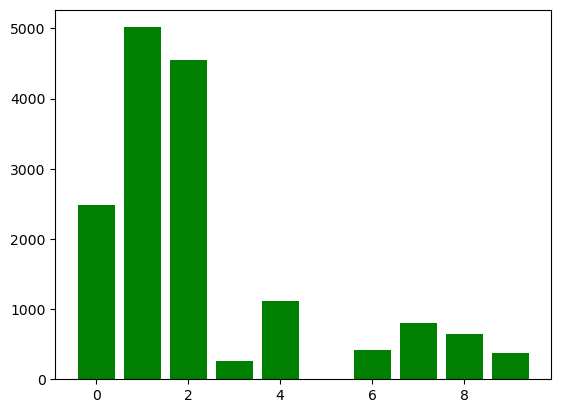

In [17]:
CLASS_TO_DELETE = 5

def remove_images(label):
    annotations = pd.read_csv(paths['ANNOTATION_FILE_PATH'])
    target = annotations[annotations['Class'] == label]
    img_names = list(target['Path']) #get images name
    for image in img_names:  # Go over each image name to be deleted
      f = os.path.join(paths['TRAIN_PATH'],str(label),image)  # Create valid path to image
      if os.path.exists(os.path.join(paths['TRAIN_PATH'],str(label),image)):
        os.remove(f)  # Remove the image

remove_images(CLASS_TO_DELETE)
plotTrainingDistribution()

{0: 2488, 1: 3000, 2: 3000, 3: 257, 4: 1122, 6: 415, 7: 797, 8: 645, 9: 380}


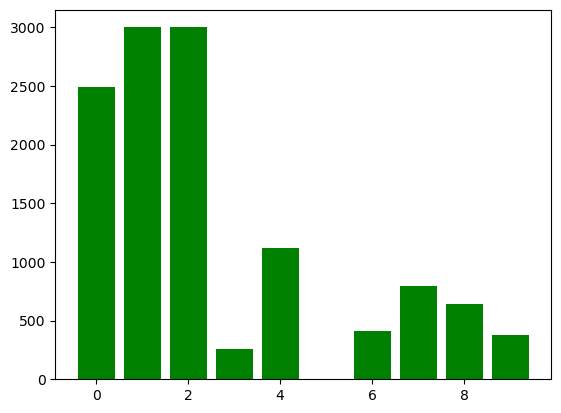

In [18]:
import random

def undersample(label,n):
    img_names = os.listdir(os.path.join(paths['TRAIN_PATH'],str(label)))
    img_names = random.sample(img_names,n)  # Pick n random images to remove
    for image in img_names:  # Go over each image name to be deleted
      f = os.path.join(paths['TRAIN_PATH'],str(label),image)  # Create valid path to image
      os.remove(f)  # Remove the image

N_IMG_TO_DELETE = [2017,1551]
CLASSES_TO_REDUCE = [1,2]

for i in range(len(CLASSES_TO_REDUCE)):
    undersample(CLASSES_TO_REDUCE[i], N_IMG_TO_DELETE[i])

plotTrainingDistribution()

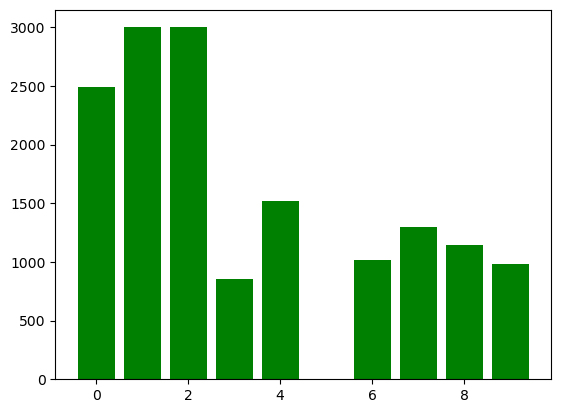

{0: 2488, 1: 3000, 2: 3000, 3: 858, 4: 1523, 6: 1016, 7: 1298, 8: 1146, 9: 981}


In [25]:
import keras.utils as image

CLASSES_TO_AUGMENT = [3,4,6,7,8,9]
N_IMG_TO_AUGMENT = [600,400,600,500,500,600]

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.1,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

def augment_images(label,number_images):
    number_images = int(number_images)
    path = os.path.join(paths['TRAIN_PATH'],str(label))
    i = 0
    while i < number_images:
        for f in os.listdir(path):
          img = image.load_img(os.path.join(paths['TRAIN_PATH'],str(label),f), target_size=(69, 69))
          x = image.img_to_array(img)
          x = x.reshape((1,) + x.shape)
          for batch in datagen.flow(x, batch_size=1):
              new_image = image.array_to_img(batch[0])
              new_image.save(os.path.join(paths['TRAIN_PATH'],str(label),"aug_" + str(i) +".jpg"))
              i += 1
              if i > number_images:
                  return
              break

for i in range(len(CLASSES_TO_AUGMENT)):
    augment_images(CLASSES_TO_AUGMENT[i], N_IMG_TO_AUGMENT[i])

plotTrainingDistribution()

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)
    # to perform normalization we should never use information coming from the test set, only training set

train_dir=paths['TRAIN_PATH']

# TODO: Consider if the output should be normalized
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')

Found 15684 images belonging to 10 classes.


In [11]:
# validation set image data generator
val_datagen = ImageDataGenerator(rescale=rescale_size) # it should not be augmented

validation_dir=paths['EVAL_PATH']

validation_generator = val_datagen.flow_from_directory(validation_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')

Found 3922 images belonging to 10 classes.


# 3. Model creation

In [12]:
# Function used to create the CNN structure used for regression
def create_cnn(width, height, depth, num_classes,filters=(16, 32, 64)):
    inputShape = (height, width, depth)
    chanDim = -1
    model = models.Sequential()
    for (i, f) in enumerate(filters):
        # first CONV layer set appropriately
        if i == 0:
            model.add(Conv2D(f, (3, 3), activation="relu", padding="same", input_shape=inputShape))
        else:
            model.add(Conv2D(f, (3, 3), activation="relu", padding="same"))
        # size of the patches typically 3x3 or 5x5
        # determine if we need to change padding or stride, with padding = same we are able to center convolutional windows around every input tile, in order to have always the same size of the input image
        # model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    # FLATTEN => FC => RELU => BN => DROPOUT
    model.add(Flatten())
    #model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu")) # consider if we need to add this dense layer before with more units, such as 64 in order to shrink in two different stages, depends on the outpout size of flatten
    #model.add(BatchNormalization(axis=chanDim))
    model.add(Dense(num_classes, activation="softmax"))
    return model

model = create_cnn(input_width, input_height, 3, 9, (16,32))
model.summary()

2022-12-18 09:45:39.170266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 8)         224       
                                                                 
 batch_normalization (BatchN  (None, 69, 69, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 34, 34, 16)       64        
 hNormalization)                                                 
                                                        

In [13]:
# compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

# 4. Model training

In [26]:
number_training = 0;
for i in range(10):
      if i == 5:
        continue
      path = os.path.join(paths['TRAIN_PATH'],str(i))
      n_images = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
      number_training += n_images

number_eval = 0;
for i in range(10):
      if i == 5:
        continue
      path = os.path.join(paths['EVAL_PATH'],str(i))
      n_images = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
      number_eval += n_images

In [ ]:
# steps_per_epoch: number of batches to be drawn from the generator after assuming epoch over
# epochs: number of epochs
# validation_steps: how many batches to draw from the validation generator for evaluation

history = model.fit(
      train_generator,
      steps_per_epoch=int(math.ceil((1. * number_training) / batch_size)),
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=int(math.ceil((1. * number_eval) / batch_size)))

Epoch 1/300
785/785 [==============================] - 87s 110ms/step - loss: 1.8422 - accuracy: 0.3947 - val_loss: 1.6217 - val_accuracy: 0.4653
Epoch 2/300
785/785 [==============================] - 88s 112ms/step - loss: 1.6484 - accuracy: 0.4316 - val_loss: 1.5210 - val_accuracy: 0.4605
Epoch 3/300
785/785 [==============================] - 97s 124ms/step - loss: 1.5477 - accuracy: 0.4507 - val_loss: 1.3981 - val_accuracy: 0.4921
Epoch 4/300
785/785 [==============================] - 84s 106ms/step - loss: 1.4888 - accuracy: 0.4574 - val_loss: 1.3604 - val_accuracy: 0.4980
Epoch 5/300
785/785 [==============================] - 79s 101ms/step - loss: 1.4337 - accuracy: 0.4742 - val_loss: 1.3221 - val_accuracy: 0.5209
Epoch 6/300
785/785 [==============================] - 107s 137ms/step - loss: 1.4068 - accuracy: 0.4762 - val_loss: 1.3275 - val_accuracy: 0.5107
Epoch 7/300
785/785 [==============================] - 85s 109ms/step - loss: 1.3854 - accuracy: 0.4892 - val_loss: 1.2583 

# 5. Visualization

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

In [ ]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation ACC')
plt.legend()
plt.figure()

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# smooth curves if they look noisy
# replace each point with an exponential moving average of the previous points
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [ ]:
plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation MAE')
plt.legend()
plt.figure()

In [ ]:
plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
# display average, the model may improve even if not reflected

# 6. Early stopping

In [ ]:
import keras
import os

callbacks_list = [
        # interrupts training when accuracy has stopped improving accuracy on the validation set for at least 3+1=4 epochs
        keras.callbacks.EarlyStopping(
            monitor='acc', # should be part of the metrics specific during compilation
            patience=10,
        ),
        # save the current weights after every epoch
        #keras.callbacks.ModelCheckpoint(
        #    filepath=os.path.join(paths['MODELS'],'CNN_baseline.h5'),
        #    monitor='val_loss', # do not overwrite until val_loss is improved
        #    save_best_only=True
        #),
        # monitor the model's validation loss and reduce the LR when the validation loss has stopped improving, effective strategy to escape local minima
        #keras.callbacks.ReduceLROnPlateau(
        #    monitor='val_loss',
        #    factor=0.2, # divides LR by 5 when triggered
        #    patience=3 # called when stopped improving for 3 epochs
        #),
        #keras.callbacks.TensorBoard(
        #    log_dir=paths['LOG_DIR'],
        #    write_graph=True,
        #    histogram_freq=1 # record activation histograms every 1 epoch
        #)
]

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=int(math.ceil((1. * number_training) / batch_size)),
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=int(math.ceil((1. * number_eval) / batch_size)),
      callbacks=callbacks_list)

# 7. Model testing

In [ ]:
test_dir=paths["TEST_PATH"]
test_datagen = ImageDataGenerator(rescale=rescale_size) # it should not be augmented

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')

# if performances are much wors than validation ones, during hyperparameter optimization (when done) the process has overfitted the validdation set, if so go to a more clear protocol such as Kfold CV
test_loss, test_acc = model.evaluate_generator(test_generator, steps=2)
print('test acc:', test_acc)
print('test loss:', test_loss)

In [ ]:
# TODO: is it balanced? If not consider ROC AUC for example, FPR, TPR, and others

# 8. Model exportation

In [ ]:
model.save("models/CNN_baseline.h5")

# 9. Plot model as graph of layers

In [ ]:
from keras.utils import plot_model

In [ ]:
plot_model(model, show_shapes=True, to_file='model.png')